# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [376]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [377]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('state', 'TA01_output'),
    ('temperatures', 'DC_GT101_GM101'),
    ('temperatures', 'DC_GT102_GM102'),
    ('temperatures', 'DC_GT103_GM103'),
    ('temperatures', 'DC_GT104_GM104'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'DC_GT401_GM401'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('sun', 'vol'),
    ('sun', 'vol_deriv'),
    ('time', 'dayofyear'),
    ('time', 'monthofyear'),
    ('time', 'minofday'),
    ('time', 'hourofday')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [378]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
state         TA01_output         14
temperatures  DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      11
              DC_GT104_GM104      11
              DC_GT401_GM401      13
              TA01_GT401_GM401    13
              TA02_GT401_GM401    12
              DC_GT301_damped     11
              DC_GT301_outdoor    12
humidity      DC_GT101_GM101      12
              DC_GT102_GM102      12
              DC_GT103_GM103      12
              DC_GT104_GM104      10
              DC_GT401_GM401      13
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  1
              gsi_deriv            1
              vol                  1
              vol_deriv            1
time          dayofyear            1
              monthofyear          1
              minofday             1
              hourofday            1
dtype: int64





In [379]:
# remove single NAN
data = data.dropna(how='any')

In [380]:
# # describe cols
# data.describe().transpose()

In [381]:
# steps = 20
# test = (data.temperatures.DC_GT301_damped - data.temperatures.DC_GT301_damped.rolling(window=steps, center=False).mean())
# test2 = test.rolling(window=20).mean()

# test3 = (data.flow.TA01_GP101 - data.flow.TA01_GP101.rolling(window=120, center=False).mean())


# fig, ax1 = plt.subplots()
# # ax1.plot(data.temperatures.DC_GT301_damped.values[-150:], 'b')
# # ax1.plot(test.values[-15000:-10000], 'b')
# ax1.plot(data.flow.TA01_GP101.values[-150:], 'b')
# # ax1.plot(data.time.minofday.values[-45000:-42000], 'b')
# # ax1.plot(data.temperatures.DC_GT401_GM401.values[-15000:-10000], 'b')

# ax2 = ax1.twinx()

# ax2.plot(data.sun.gsi_deriv.values[-150:])
# ax2.plot(data.temperatures.TA01_GT10X_GM10X.values[-150:], 'r')

In [382]:
# subset = data[data.state.TA01_output > 35].copy()

# test = subset.flow.TA01_GP101.rolling(window=30, center=False).mean()
# test2 = subset.temperatures.TA01_GT10X_GM10X.rolling(window=30, center=False).apply(lambda vec: vec[-1], raw=True)

# fig, ax1 = plt.subplots()
# ax1.plot(subset.flow.TA01_GP101.values[-250:], 'b')
# ax1.plot(test.values[-250:], 'b')

# ax2 = ax1.twinx()

# # ax2.plot(subset.temperatures.TA01_GT10X_GM10X.values[-100:], 'r')
# ax2.plot(test2.values[-250:], 'r')

In [383]:
# fig, ax1 = plt.subplots()
# ax1.plot(test.values[-260:-10], 'b')

# ax2 = ax1.twinx()

# # ax2.plot(subset.temperatures.TA01_GT10X_GM10X.values[-100:], 'r')
# ax2.plot(xhat[-250:], 'r')

## Feature engineering

### GH Temperature

In [384]:
### create "better" estimate of temperature var, w. proper avg.
data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [385]:
# adjust for setpoint change
col1 = ('temperatures', 'TA01_GT10X_GM10X')
col2 = ('setpoints', 'TA01_GT10X_GM10X')
data[col1] = data[col1] - data[col2]

# set min to zero
data[col1] = data[col1] + abs(data[col1].min())

# # min-max scale, i.e. squeeze into [0, 1]
# data[col1] = (data[col1] - data[col1].min()) / (data[col1].max() - data[col1].min())


In [388]:
# # make TEMP zero-centered around setpoints w. variance scaling
# data[('temperatures', 'TA01_GT10X_GM10X')] = \
#     (data[('temperatures', 'TA01_GT10X_GM10X')] \
#      - data[('setpoints', 'TA01_GT10X_GM10X')]) \
#     / data[('temperatures', 'TA01_GT10X_GM10X')].std()

# # col = ('temperatures', 'TA01_GT10X_GM10X')
# # data[col] = (data[col] - data[col].mean()) / data[col].std()

### DC temperature

In [389]:
### min-max scale [btween 0 and 1]
col = ('temperatures', 'DC_GT401_GM401')
# data[col] = (data[col] - data[col].mean()) / data[col].std()
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### scale by fan output
data[col] = data[col] * data[('state', 'TA01_output')] / data[('state', 'TA01_output')].min()

### OUTSIDE temperature

In [390]:
### normalize vals
col = ('temperatures', 'DC_GT301_damped')
# data[col] = (data[col] - data[col].mean()) / data[col].std()

#min-max scale vals
data[col] = data[col] + abs(data[col].min())
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### GH Humidity

In [392]:
### create "better" estimate of temperature var, w. proper avg.
data[('humidity', 'TA01_GT10X_GM10X')] = data.humidity[[
    # ('DC_GT102_GM101'),
    ('DC_GT102_GM102'), 
    ('DC_GT103_GM103'), 
    ('DC_GT104_GM104')
]].values.mean(axis=1)

In [393]:
### normalize humidity
col = ('humidity', 'TA01_GT10X_GM10X')
# data[col] = (data[col] - data[col].mean()) / data[col].std()

# min-max scale vals
# data[col] = data[col] + data[col].mean()
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

### Solar radiance

In [394]:
# ### min-max scale GSI
col = ('sun', 'gsi')
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# # create INDICATOR f. GSI
# data[('sun', 'gsi')] = data.sun.gsi.apply(lambda val: val > 1e-3)

In [395]:
### zero-centered variance scale GSI deriv
col = ('sun', 'gsi_deriv')
data[col] = data[col] / data[col].std()

### Flow volume

In [396]:
### create INDICATOR variable f. TA01_output
data[('state', 'TA01_output')] = data.state.TA01_output.apply(lambda val: val > 35)

In [397]:
# ### normalize and min-max scale flow (i.e. squeeze into [0, 1])
# mask = data.state.TA01_output.values
# col = ('flow', 'TA01_GP101')

# ### min-max scale w.r.t. MASK
# data.loc[mask, col] = (data[mask][col] - data[mask][col].min()) / (data[mask][col].max() - data[mask][col].min())
# data.loc[~mask, col] = 0
# # data.loc[~mask, col] = (data[~mask][col] - data[~mask][col].min()) / (data[~mask][col].max() - data[~mask][col].min())

# # ### normalize w.r.t. MASK
# # data.loc[mask, col] = (data[mask][col] - data[mask][col].mean()) / data[mask][col].std()
# # data.loc[~mask, col] = (data[~mask][col] - data[~mask][col].mean()) / data[~mask][col].std()

In [398]:
### normalize and min-max scale flow (i.e. squeeze into [0, 1])
col = ('flow', 'TA01_GP101')
data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

## Kalman filtering

In [399]:
cols = [
    (('temperatures', 'TA01_GT10X_GM10X'), 3),
    (('temperatures', 'DC_GT401_GM401'), 2),
    (('temperatures', 'DC_GT301_damped'), 4),
    (('humidity', 'TA01_GT10X_GM10X'), 3),
    
]

for colSpec in cols:
    # apply KALMAN filter to temperature measurements
    col = colSpec[0]
    varExp = colSpec[-1]
    
    # get data
    X = data[col].values
    n = len(X)

    # process variance, measurement variance
    Q = 1e-5
    R = 0.1**varExp

    xhat=np.zeros(n)      # a posteri estimate of x
    P=np.zeros(n)         # a posteri error estimate
    xhatminus=np.zeros(n) # a priori estimate of x
    Pminus=np.zeros(n)    # a priori error estimate
    K=np.zeros(n)         # gain or blending factor

    # intial guesses
    xhat[0] = X[0]
    P[0] = X[1]

    for k in range(1,n):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(X[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    data[col] = xhat

## Data preparation

In [484]:
t_steps = 20   # 10-min predictions
n_steps = 40   # 20-min backwards look

train_frac = 0.9

### Data selection and split

In [517]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'gsi_deriv'),
    ('state', 'TA01_output'),
    ('time', 'minofday'),
    #('time', 'hourofday'),
    #('time', 'dayofyear'),
    #('time', 'monthofyear')
]

# filter data
testData = data[model_vars].copy()
# testData = testData[(testData.index.get_level_values(0) == 3) & (testData.index.get_level_values(1) >= 5)]
testData = testData[(testData.index.get_level_values(0) >= 2)]

In [518]:
# targets = testData.pop(('temperatures', 'TA01_GT10X_GM10X')).copy()
targets = testData[('temperatures', 'TA01_GT10X_GM10X')].copy()
# targets = targets.shift(-t_steps) - targets

In [519]:
testData[('flow', 'TA01_GP101')] = testData[('flow', 'TA01_GP101')].rolling(n_steps).sum()
testData[('temperatures', 'TA01_GT10X_GM10X')] = testData[('temperatures', 'TA01_GT10X_GM10X')].rolling(t_steps).apply(lambda vec: vec[0], raw=True)
testData[('temperatures', 'DC_GT401_GM401')] = testData[('temperatures', 'DC_GT401_GM401')].rolling(n_steps).mean()
testData[('temperatures', 'DC_GT301_damped')] = testData[('temperatures', 'DC_GT301_damped')].rolling(n_steps).mean()
testData[('humidity', 'TA01_GT10X_GM10X')] = testData[('humidity', 'TA01_GT10X_GM10X')].rolling(n_steps).mean()
testData[('sun', 'gsi')] = testData[('sun', 'gsi')].rolling(n_steps).max()
testData[('sun', 'gsi_deriv')] = testData[('sun', 'gsi_deriv')].rolling(n_steps).mean()
testData[('state', 'TA01_output')] = testData[('state', 'TA01_output')].rolling(n_steps).max()
testData[('time', 'minofday')] = testData[('time', 'minofday')].rolling(n_steps).mean()
# testData[('time', 'hourofday')] = testData[('time', 'hourofday')].rolling(t_steps).mean()
# testData[('time', 'dayofyear')] = testData[('time', 'dayofyear')].rolling(t_steps).mean()
# testData[('time', 'monthofyear')] = testData[('time', 'monthofyear')].rolling(t_steps).mean()

### Remove outliers due to missing days and hours

In [520]:
testData['day'] = testData.index.get_level_values(1)
testData['hour'] = testData.index.get_level_values(2)

# check diff in days
mask1 = np.abs(testData.day - testData.shift(n_steps).day) < 2

# check diff in hrs
mask2 = np.abs(testData.hour - testData.shift(n_steps).hour) < 2

# remove cols
del testData['day'], testData['hour']

# filter out erroneous sequences
testData = testData[mask1 & mask2]
targets = targets[mask1 & mask2]

### Shuffle and split dataset

In [521]:
features = testData.iloc[n_steps:].values
targets = targets.iloc[n_steps:].values

In [522]:
# save sequential seqs, targets for testing/visualizations
# features, test_feats  = features[:-8640], features[-8640:]
# targets, test_targets = targets[:-8640], targets[-8640:]
features, test_feats  = features[5760:], features[:5760]
targets, test_targets = targets[5760:], targets[:5760]

In [523]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
features = np.squeeze(features[idxs])
targets = np.squeeze(targets[idxs])

In [524]:
# split data
train_n = int(len(targets) * train_frac)

X_train, X_test = features[:train_n], features[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [525]:
# # delete vars
# del sequences, targets

## Define Gradient Boosting Regressor

In [526]:
from sklearn import ensemble

params = {
    'n_estimators': 5000,
    'max_depth': 5,
    'subsample': 0.5,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'learning_rate': 0.01,
    'loss': 'squared_error',
}

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, Y_train)

In [514]:
exp_feat = test_feats.copy()
exp_feat[:, 0] = 20
# exp_feat[:, 1] += 0.2
# exp_feat[:, 0] -= 2

In [515]:
preds = reg.predict(exp_feat)

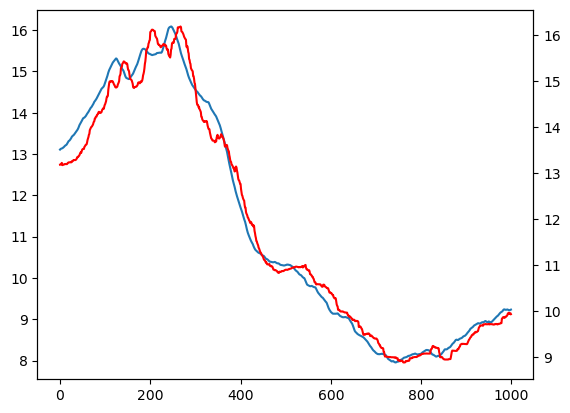

In [516]:
fig, ax1 = plt.subplots()
# ax1.plot(test_targets)
ax1.plot(test_targets[1000:2000])
# ax1.plot(preds[-1500:], 'r')

ax2 = ax1.twinx()
# ax2.plot(preds, 'r')
ax2.plot(preds[1000:2000], 'r')
# ax2.plot(exp_feat[-1500:, 3])

In [ ]:
preds_test = reg.predict(X_test)

In [ ]:
plt.plot(Y_test[-200:])
plt.plot(preds_test[-200:])
# plt.ylim(-1, 1)

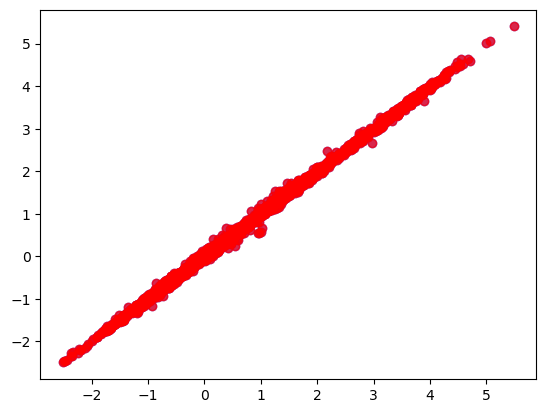

In [94]:
n = 0
error = 0

X_test_exp = X_test.copy()
testpreds = reg.predict(X_test_exp)
plt.scatter(Y_test[n:], testpreds[n:], c='b', alpha=0.5)

X_test_exp[:, 0] += error
testpreds = reg.predict(X_test_exp)
plt.scatter(Y_test[n:], testpreds[n:], c='r', alpha=0.7)

In [ ]:
dayData = data.groupby(['month', 'day']).mean()
dayData = dayData[dayData.index.get_level_values(0) != 3]

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(dayData.temperatures.TA01_GT10X_GM10X.values, 'r')

ax2 = ax1.twinx()
ax2.plot(-dayData.flow.TA01_GP101.values, 'b')